In [44]:
from subprocess import check_output
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 20

file is turned into a csv file - downloaded from Kaggle

In [45]:
train_df = pd.read_csv('fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('fashion-mnist_test.csv', sep = ',')

In [46]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now it is observed that the first column is the label data and because it has 10 classes so it is going to have from 0 to 9.The remaining columns are the actual pixel data.Here as you can see there are about 784 columns that contain pixel data. Here each row is a different image representation in the form pixel data.

Now let us split the train data into x and y arrays where x represents the image data and y represents the labels.

To do that we need to convert the dataframes into numpy arrays of float32 type which is the acceptable form for tensorflow and keras.

In [48]:
train_data = np.array(train_df, dtype = 'float32')

In [49]:
test_data = np.array(test_df, dtype='float32')

Now let us slice the train arrays into x and y arrays namely x_train,y_train to store all image data and label data respectively. i.e

x_train contains all the rows and all columns except the label column and excluding header info .
y_train contains all the rows and first column and excluding header info .
Similarly slice the test arrays into x and y arrays namely x_train,y_train to store all image data and label data respectively. i.e

x_test contains all the rows and all columns except the label column and excluding header info .
y_test contains all the rows and first column and excluding header info .


Important Note : Since the image data in x_train and x_test is from 0 to 255 , we need to rescale this from 0 to 1.To do this we need to divide the x_train and x_test by 255 . It's important that the training set and the testing set be preprocessed in the same way

In [50]:
x_train = train_data[:,1:]/255

y_train = train_data[:,0]

x_test= test_data[:,1:]/255

y_test=test_data[:,0]

In [51]:
y_train

array([2., 9., 6., ..., 8., 8., 7.], dtype=float32)

In [52]:
y_test

array([0., 1., 2., ..., 8., 8., 1.], dtype=float32)

Now we are gonna split the training data into validation and actual training data for training the model and testing it using the validation set. This is achieved using the train_test_split method of scikit learn library.

In [53]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

Now let us visualise the some samples after the resize of the data which needs to be ready for train the network .

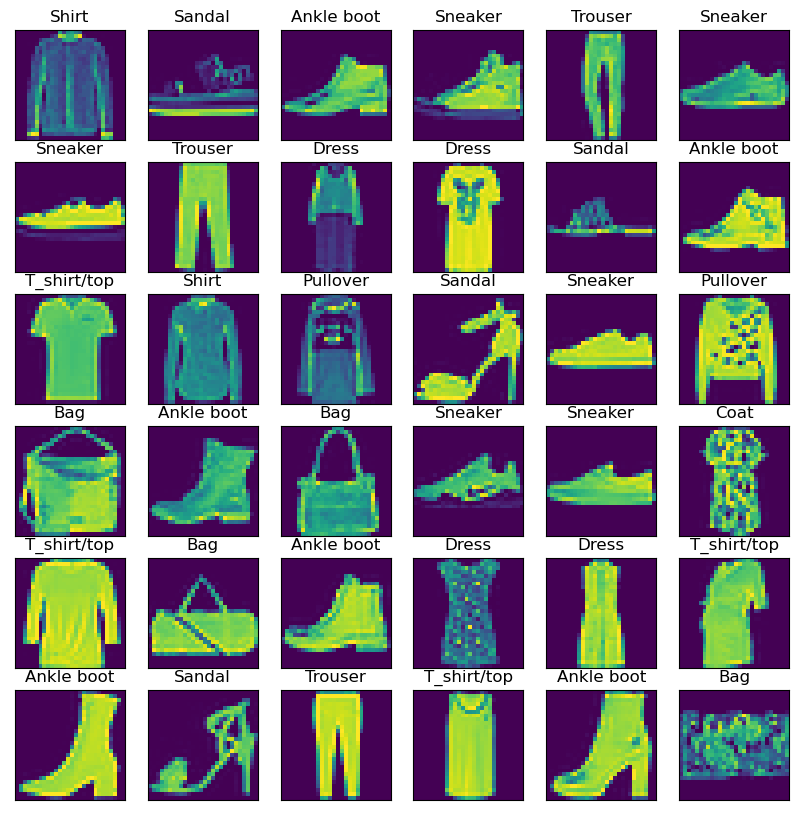

In [54]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])
plt.show()

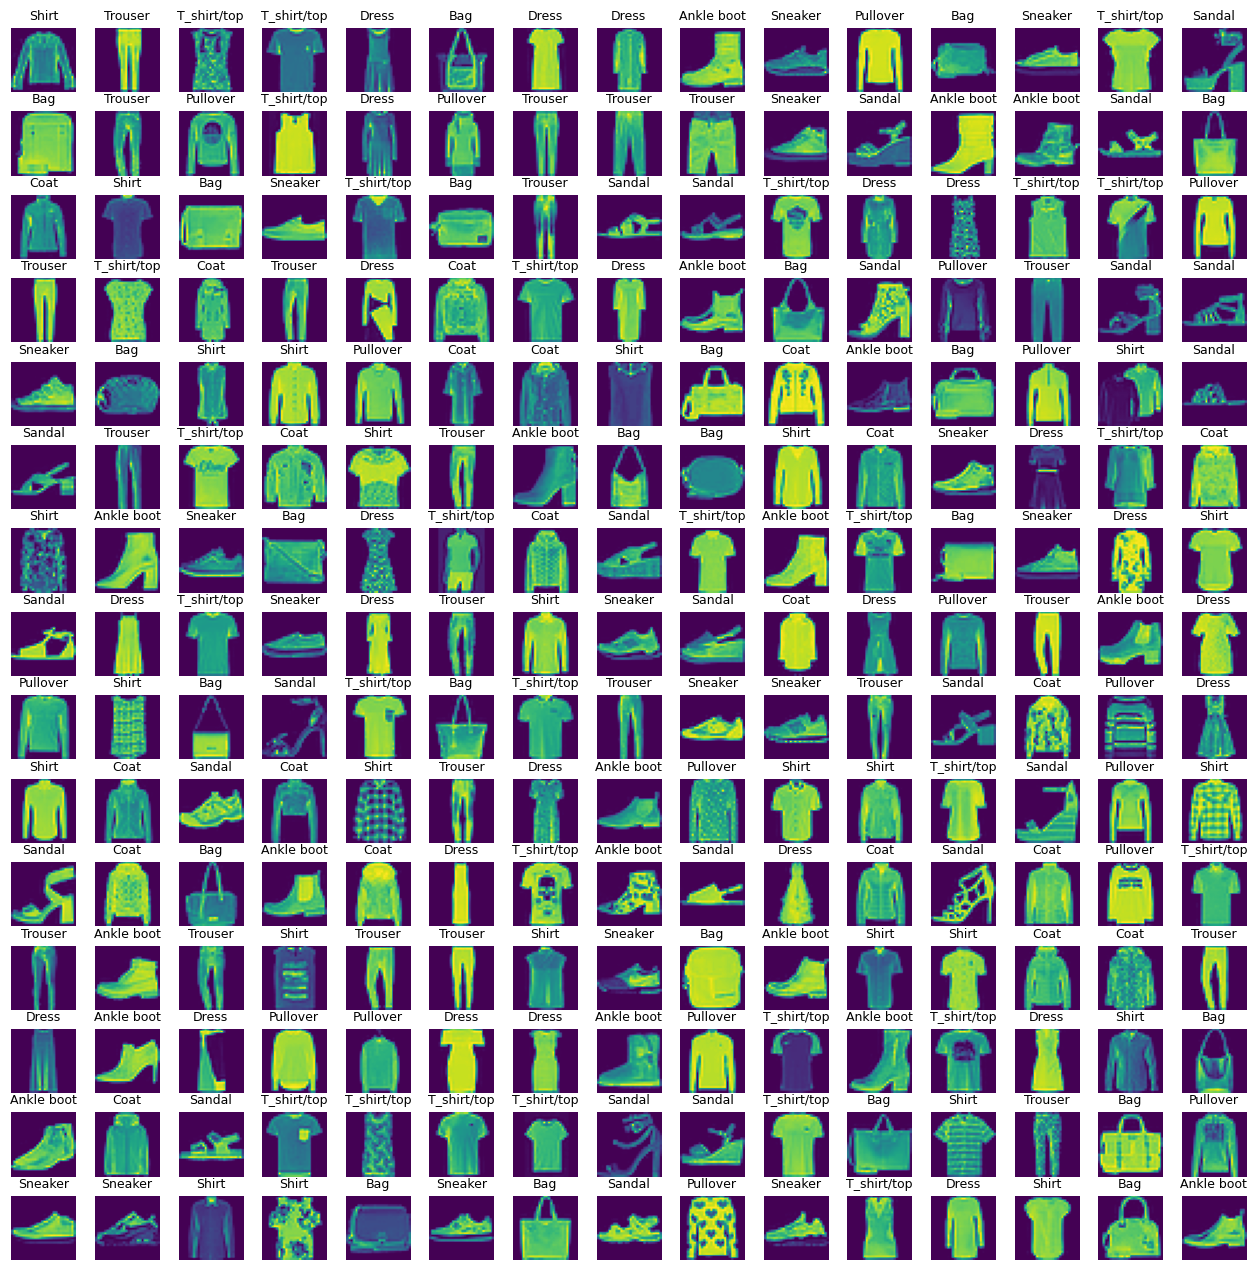

In [55]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,16))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_train = len(train_data) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow( train_data[index,1:].reshape((28,28)) )
    labelindex = int(train_data[index,0])
    axes[i].set_title(class_names[labelindex], fontsize = 9)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.3)

First of all let us define the shape of the image before we define the model. Defined the shape of the image as 3d with rows and columns and 1 for the 3d visualisation

In [56]:
image_rows = 28
image_cols = 28
batch_size = 4096
image_shape = (image_rows,image_cols,1) 

Now we need to do more formating on the x_train,x_test and x_validate sets

In [57]:
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_validate = x_validate.reshape(x_validate.shape[0],*image_shape)

Define the model

The first layer in model network, keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). This layer unstacks rows of pixels in the image and lining them up and has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 32 nodes (or neurons). The second (and last) layer is a 10-node softmax layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

In [58]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
    
])

Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.Here we will use "sparse_categorical_crossentropy"

Optimizer —This is how the model is updated based on the data it sees and its loss function.

Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [59]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

Train Model:
    
Training the neural network model requires the following steps:

Feed the training data to the model. In this example, the training data is in the x_train and y_train arrays.
The model learns to associate images and labels.
You ask the model to make predictions about a test set—in this example, the x_test array. Verify that the predictions match the labels from the y_test array.
To start training, call the model.fit method—so called because it "fits" the model to the training data:

In [60]:
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=4096,
    epochs=75,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/75
12/12 [==============================] - 9s 567ms/step - loss: 1.8059 - accuracy: 0.4166 - val_loss: 1.2314 - val_accuracy: 0.6074
Epoch 2/75
12/12 [==============================] - 6s 512ms/step - loss: 0.9883 - accuracy: 0.6653 - val_loss: 0.7485 - val_accuracy: 0.7535
Epoch 3/75
12/12 [==============================] - 7s 531ms/step - loss: 0.6684 - accuracy: 0.7716 - val_loss: 0.5853 - val_accuracy: 0.7927
Epoch 4/75
12/12 [==============================] - 6s 499ms/step - loss: 0.5632 - accuracy: 0.8007 - val_loss: 0.5225 - val_accuracy: 0.8140
Epoch 5/75
12/12 [==============================] - 6s 506ms/step - loss: 0.5138 - accuracy: 0.8177 - val_loss: 0.4877 - val_accuracy: 0.8248
Epoch 6/75
12/12 [==============================] - 6s 507ms/step - loss: 0.4819 - accuracy: 0.8313 - val_loss: 0.4590 - val_accuracy: 0.8388
Epoch 7/75
12/12 [==============================] - 6s 505ms/step - loss: 0.4576 - accuracy: 0.8421 - val_loss: 0.4390 - val_accuracy: 0.8477
Epoch 

Let us plot the Training Accuracy vs Loss to get a better understanding of the model training.

Text(0.5, 1.0, 'Train - Accuracy')

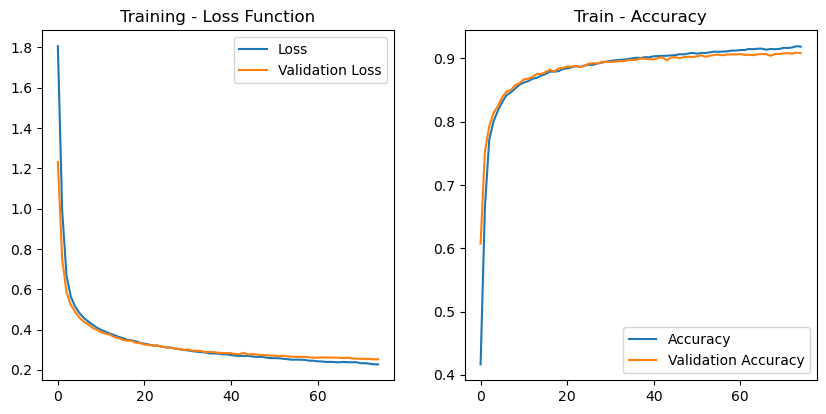

In [61]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

Evaluate / Score the model

In [62]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2519
Test Accuracy : 0.9118


Results

Lets plot training and validation accuracy as well as loss

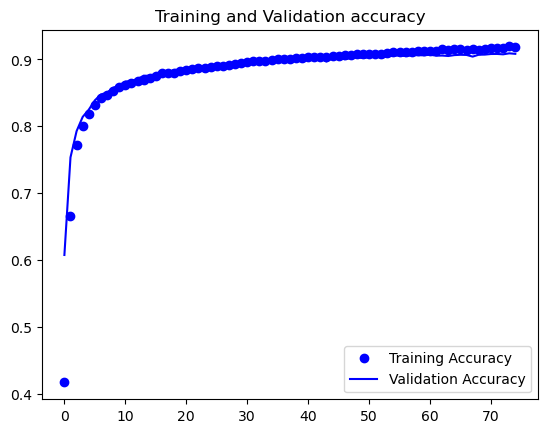

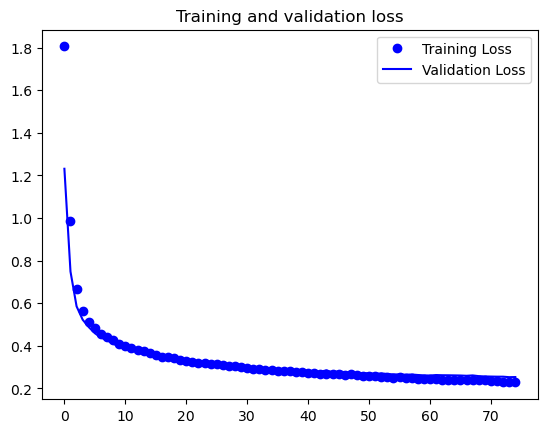

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Classification Report

We can summarize the performance of our classifier as follows

In [65]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2519
Test Accuracy : 0.9118


In [68]:
#Get the predictions for the test data
predicted_classes = cnn_model.predict_classes(x_test)
#Get the indices to be plotted
y_true = test_df.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

AttributeError: 'Sequential' object has no attribute 'predict_classes'

can't run the last part as need to update keras - have a new laptop so will install everything new when up and running